<a href="https://colab.research.google.com/github/williamfrankholland/MMAI-Deep-Learning/blob/main/colab/Waste_Classification_ResNet_Bill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install focal-loss

import pandas as pd
import numpy as np
import glob
import PIL
from PIL import Image

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv3D, Flatten, MaxPooling2D, AveragePooling2D

from sklearn.utils import shuffle
from tensorflow.keras import Model

from sklearn.metrics import classification_report

from focal_loss import SparseCategoricalFocalLoss

SHAPE_SIZE = 180


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
imdir = '/content/gdrive/MyDrive/MMAI 894 Team Project/data_clean/'
image_classes = ['battery/','biological/','brown-glass/','cardboard_recycle/','clothes_donate/','clothes_garbage/','green_glass_recycle/','metal_recycle/','paper_recycle/','plastic_recycle/','shoes/','trash/','white-glass/']


image_size = (SHAPE_SIZE, SHAPE_SIZE)
batch_size = 32

total_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imdir,
    #label_mode="categorical",
    label_mode="int",
    #validation_split=0.2,
    subset=None,
    seed=1337,
    image_size=image_size,
    #batch_size=batch_size,
    batch_size=None,
    shuffle=False
)

'''
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imdir,
    #label_mode="categorical",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    #batch_size=batch_size,
    # Don't shuffle the test data to allow the confusion matrix to be created
    #shuffle=False
)
'''



Found 10038 files belonging to 17 classes.


'\ntest_ds = tf.keras.preprocessing.image_dataset_from_directory(\n    imdir,\n    #label_mode="categorical",\n    label_mode="int",\n    validation_split=0.2,\n    subset="validation",\n    seed=1337,\n    image_size=image_size,\n    #batch_size=batch_size,\n    # Don\'t shuffle the test data to allow the confusion matrix to be created\n    #shuffle=False\n)\n'

In [6]:
print(total_ds)
print(total_ds.cardinality().numpy())

<PrefetchDataset element_spec=(TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
10038


In [7]:
# Function to create a train, val, test split from a data set object
def get_dataset_partitions_tf(ds, ds_size, train_split=0.5, val_split=0.2, test_split=0.3, shuffle=True, shuffle_size=10000, batch_size=32):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        # Note must set reshuffle_each_iteration to False to avoid data leakage
        ds = ds.shuffle(shuffle_size, seed=12, reshuffle_each_iteration = False)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size).batch(batch_size)
    val_ds = ds.skip(train_size).take(val_size).batch(batch_size)
    test_ds = ds.skip(train_size).skip(val_size).batch(batch_size)
    
    return train_ds, val_ds, test_ds

In [8]:
# Get the data set size to calculate the right split
# When batched this is the number of batches not item count
batch_count = total_ds.cardinality().numpy()
print(batch_count)

# Split the data into three parts
train_ds, val_ds, test_ds = get_dataset_partitions_tf(total_ds, batch_count, train_split=0.7, 
                                                      val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000, batch_size=batch_size)

# Check that the split worked
print(train_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())


10038
220
63
32


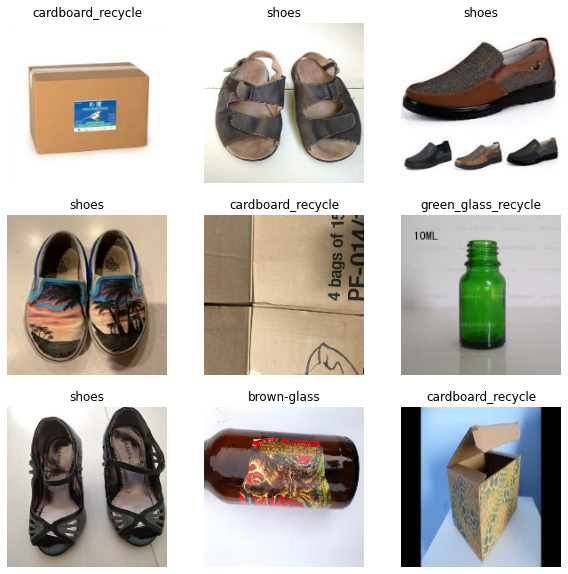

In [9]:
# Get the first batch of 32 then print the first 9 items
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(int(labels[i]))
        plt.title(total_ds.class_names[labels[i]])
        plt.axis("off")

In [10]:
def build_model():


    # Create the base model layers - need to use ResNet50V2
    base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(SHAPE_SIZE, SHAPE_SIZE, 3))
    base_model.trainable = False

    #print(type(base_model))

    input_layer = keras.layers.Input([SHAPE_SIZE, SHAPE_SIZE, 3])
    x = keras.layers.RandomTranslation( height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))(input_layer)
    pre_process = keras.applications.resnet_v2.preprocess_input(x)

    x = base_model(pre_process)

    #model.add(keras.layers.Resizing(
    #SHAPE_SIZE, SHAPE_SIZE, interpolation="bilinear", crop_to_aspect_ratio=True)

    # Scale to -1 to 1 
    #model.add(keras.layers.Rescaling(scale=1.0/127.5, offset=-1.0))
    #model.add(keras.layers.Rescaling(scale=1.0/255))
    
    # Conv2+ReLU: [5x5, 32] strides=2 MaxPooling: [4x4] strides=2
    x = keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation="relu", name="Conv2d-1", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Activation("relu")(x)
    #x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="Pool-1", padding="same", strides=2)(x)

    # Conv2+ReLU: [3x3, 64] MaxPooling: [4x4]
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="Conv2d-2", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    #model.add(keras.layers.Activation("relu"))
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="Pool-2", padding="same", strides=2)(x)

    # Conv2+ReLU: [3x3, 256] MaxPooling: [4x4]
    x = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", name="Conv2d-3", padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    # model.add(keras.layers.Activation("relu"))
    #x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="Pool-3", padding="same", strides=2)(x)

    # Conv2+ReLU: [3x3, 512] BatchNorm MaxPooling: [3x3]
    #x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", name="Conv2d-4", padding='same')(x)
    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.MaxPooling2D(pool_size=(3, 3), name="Pool-4", padding="same")(x)

    # Conv2+ReLU: [3x3, 512] MaxPooling: [3x3]
    x = keras.layers.SeparableConv2D(filters=512, kernel_size=(3, 3), activation="relu", name="Conv2d-5", padding='same')(x)
    # New item
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same", name="Pool-5", strides=2)(x)
    
    # Flatten out the images before we pass to the dense layers
    x = keras.layers.Flatten()(x)

    # Start with more neurons 256
    x = keras.layers.Dense(512, activation="relu", name="Denselayer1")(x)
    # Drop rate = 25%
    x=keras.layers.Dropout(rate=0.4, name="drop_1_25")(x)

    # Narrow the data size 128
    x=keras.layers.Dense(128, activation="relu", name="Denselayer2")(x)
    # Drop rate = 25%
    x=keras.layers.Dropout(rate=0.4, name="drop_2_25")(x)

    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = keras.initializers.GlorotNormal(seed=42)

    #output layer for 13 classes, using softmax activation
    output_layer = Dense(17, 
                    activation='softmax',
                    kernel_initializer=weight_initializer,  
                    kernel_constraint=None,
                    )(x)

    model = Model(input_layer, output_layer)
    model.summary()

    return model

def compile_model(model):

    model.compile(
       #use catgorical crossentropy loss
       #loss=keras.losses.categorical_crossentropy,

       loss=SparseCategoricalFocalLoss(gamma=3),

        # Current version
        #loss=keras.losses.sparse_categorical_crossentropy,

        #use Adam gradient descent optimizer
        optimizer=keras.optimizers.Adam(1e-3),
       
        #use accuracy as a metric
        metrics=['accuracy']
    )

    return model

def train_model(model, train, val, epochs = 20):

    my_class_weight = {
            0: 1.0,
            1: 1.0,
            2: 2.0,
            3: 1.0,
            4: 140.0,
            5: 1.0,
            6: 10.0,
            7: 50.0,
            8: 2.0,
            9: 2.0,
            10: 1.0,
            11: 2.0,
            12: 1.0,
            13: 2.0,
            14: 9.0,
            15: 2.0,
            16: 40.0,
            }

    # Prevent an overfit by stopping early
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    #fit model with train data
    history = model.fit(
        train,
    
        #use 128 batch size, 12 epochs
        batch_size = 128,
        epochs = epochs,
        
        #class_weight=my_class_weight,

        #verbose training, including validation data
        verbose = 2,
        #validation_split = 0.2,
        validation_data = val,
        callbacks=[callback]
    )
    return model, history


def eval_model(model, test):

    #evaluate model with test data
    test_loss, test_accuracy = model.evaluate(
        test,
        verbose = 2
    )

    return test_loss, test_accuracy

def tune_model(model, train, val, epochs=5, l_rate=5e-5):
    # Unfreeze the base model
    model.trainable = True

    # Small learning rate to prevent over fitting
    model.compile( 
                  keras.optimizers.Adam(learning_rate=l_rate),
                  #loss=keras.losses.sparse_categorical_crossentropy,
                  loss=SparseCategoricalFocalLoss(gamma=3),
                  metrics=['accuracy'])

    train_model(model, train, val, epochs = epochs)
    return model

In [11]:
model = build_model()
model = compile_model(model)
model, history = train_model(model, train_ds, val_ds)

94683136/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 random_translation (RandomT  (None, 180, 180, 3)      0         
 ranslation)                                                     
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 6, 6, 2048)        2356480

In [12]:
# Now fine tune the model with a small learning rate
l_rate=5e-5
model = tune_model(model, train_ds, val_ds, epochs=10, l_rate=l_rate)
test_loss, test_accuracy = eval_model(model, test_ds)


Epoch 1/10
220/220 - 54s - loss: 0.2544 - accuracy: 0.8685 - val_loss: 0.1895 - val_accuracy: 0.8939 - 54s/epoch - 247ms/step
Epoch 2/10
220/220 - 47s - loss: 0.1119 - accuracy: 0.9162 - val_loss: 0.1688 - val_accuracy: 0.9073 - 47s/epoch - 213ms/step
Epoch 3/10
220/220 - 47s - loss: 0.0624 - accuracy: 0.9388 - val_loss: 0.1714 - val_accuracy: 0.9113 - 47s/epoch - 214ms/step
Epoch 4/10
220/220 - 47s - loss: 0.0588 - accuracy: 0.9481 - val_loss: 0.1789 - val_accuracy: 0.9108 - 47s/epoch - 213ms/step
Epoch 5/10
220/220 - 47s - loss: 0.0484 - accuracy: 0.9543 - val_loss: 0.1574 - val_accuracy: 0.9178 - 47s/epoch - 213ms/step
Epoch 6/10
220/220 - 47s - loss: 0.0505 - accuracy: 0.9533 - val_loss: 0.1567 - val_accuracy: 0.9198 - 47s/epoch - 213ms/step
Epoch 7/10
220/220 - 47s - loss: 0.0388 - accuracy: 0.9594 - val_loss: 0.1605 - val_accuracy: 0.9213 - 47s/epoch - 214ms/step
Epoch 8/10
220/220 - 47s - loss: 0.0456 - accuracy: 0.9611 - val_loss: 0.1862 - val_accuracy: 0.9188 - 47s/epoch - 214

In [13]:
print(total_ds.class_names)

['battery', 'biological', 'brown-glass', 'cardboard_recycle', 'cardboard_trash', 'clothes_donate', 'clothes_garbage', 'green_glass_broken', 'green_glass_recycle', 'metal_recycle', 'paper_recycle', 'plastic_recycle', 'shoes', 'trash', 'trash_toxic', 'white-glass', 'white-glass_broken']


In [ ]:
test_loss, test_accuracy = eval_model(model, test_ds)

33/33 - 14s - loss: 0.0492 - accuracy: 0.9858 - 14s/epoch - 409ms/step


In [14]:
# Extract the labels from the test data set
Y_test_class = tf.concat([labels for images, labels in test_ds], axis=0)

In [15]:
from tensorflow.keras.backend import argmax

# Pass the test set directly to the predict function
Y_pred_class = argmax(model.predict(test_ds))


In [16]:
#print(Y_pred_class.shape)
#print(test_labels.shape)

# Look at the lables in predict and test
print(np.unique(Y_pred_class))
print(np.unique(Y_test_class))

# Make sure the first 20 look reasonable
print(Y_pred_class[0:20])
print(Y_test_class[0:20])

[ 0  1  2  3  5  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16]
tf.Tensor([ 1  5  8 12 11  5  3 12  3 11 15  8 11 11 14 12  8 12 15 15], shape=(20,), dtype=int64)
tf.Tensor([ 1  5  8 12 15  5  3 12  3 11 15  8 11 11 14 12  8 12 15 11], shape=(20,), dtype=int32)


In [17]:
# Import libraries for EDA

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setting default fig size
size_ = (10,8)

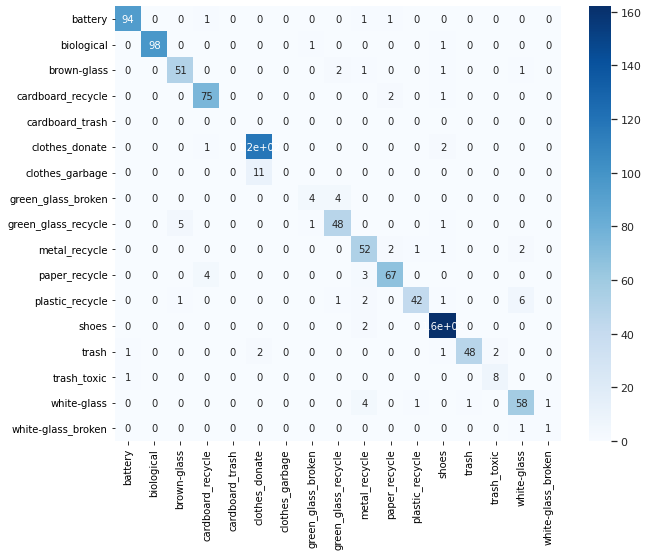

In [18]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(Y_test_class,Y_pred_class, labels = list(np.arange(17)) ) # normalize='all'
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = total_ds.class_names # ['battery','biological','brown-glass','cardboard_recycle','clothes_donate','clothes_garbage','green_glass_broken','green_glass_recycle','metal_recycle','paper_recycle','plastic_recycle','shoes','trash','trash_toxic','white-glass','white-glass_broken']
df_cm.index = total_ds.class_names # ['battery','biological','brown-glass','cardboard_recycle','clothes_donate','clothes_garbage','green_glass_broken','green_glass_recycle','metal_recycle','paper_recycle','plastic_recycle','shoes','trash','trash_toxic','white-glass','white-glass_broken']

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size viridis
plt.show()

In [19]:
# Map the multiple buckets into higher level categories
waste_map = {
    #green bin = 0, blue bin = 1, black bin = 2, hazardous waste = 3, donate = 4
    0 : 3,  #battery = 0 ->             3
    1 : 0,  #biological = 1 ->          0
    2 : 1,   #brown glass = 2 ->        1
    3 : 1,  #cardboard recycle = 3 ->   1
    4 : 2,  #cardbard garbage = 4 ->    2
    5 : 4,  #clothes donate = 5 ->      4
    6 : 2,  #clothes garbage = 6 ->     2
    7 : 2,  #green glass broken = 7 ->  2
    8 : 1,  #green glass recycle = 8 -> 1
    9 : 1,  #metal recycle = 9 ->       1
    10 : 1, #paper recycle = 10 ->      1
    11 : 1, #plastic recycle = 11 ->    1
    12 : 4, #shoes = 12 ->              4
    13 : 2, #trash = 13 ->              2
    14 : 3, #trash toxic = 14 ->        3
    15 : 1, #white glass = 15 ->        1
    16 : 2, #white glas broken = 16 ->  2
}
waste_labels = np.unique(list(waste_map.values()))
waste_labels

array([0, 1, 2, 3, 4])

In [31]:
def waste_classify(labels):
  y = np.copy(labels)
  for i in range(17):
    y = np.where(y == i, waste_map[i], y)
  return y

Y_waste_class_pred = waste_classify(Y_pred_class)
Y_waste_class_test = waste_classify(Y_test_class)

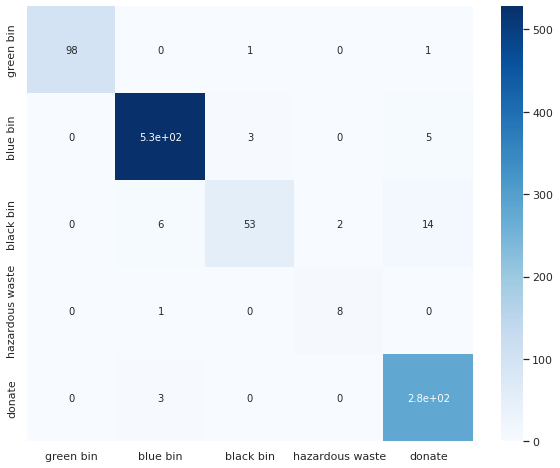

In [32]:
cm=confusion_matrix(Y_waste_class_test,Y_waste_class_pred, labels = waste_labels ) # normalize='all'
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = ['green bin','blue bin','black bin','hazardous waste','donate']
df_cm.index = ['green bin','blue bin','black bin','hazardous waste','donate']


fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="Blues") # font size viridis
plt.show()

In [29]:
print(classification_report(Y_waste_class_test,Y_waste_class_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       100
           1       0.98      0.99      0.98       536
           2       0.93      0.71      0.80        75
           3       0.80      0.89      0.84         9
           4       0.93      0.99      0.96       285

    accuracy                           0.96      1005
   macro avg       0.93      0.91      0.92      1005
weighted avg       0.96      0.96      0.96      1005



In [ ]:


# Create the base model layers
base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(SHAPE_SIZE, SHAPE_SIZE, 3))
base_model.trainable = False

#print(type(base_model))

input_layer = keras.layers.Input([SHAPE_SIZE, SHAPE_SIZE, 3])
x = keras.layers.RandomTranslation( height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15))(input_layer)
pre_process = keras.applications.resnet_v2.preprocess_input(x)

#print(type(pre_process))

x = base_model(pre_process)

x = keras.layers.Flatten()(x)

output_layer = Dense(17,
                    activation='softmax',
                    #kernel_initializer=weight_initializer,  
                    kernel_constraint=None,
                    )(x)

model = Model(input_layer, output_layer)
model.summary()

model.compile(
       #use catgorical crossentropy loss
       loss=keras.losses.sparse_categorical_crossentropy,
       #use Adam gradient descent optimizer
       optimizer=keras.optimizers.Adam(1e-3),
       
       #use accuracy as a metric
       metrics=['accuracy']
    )

model, history = train_model(model, train_ds, epochs=20)
# Create an empty model

# Add the pretrained model
#model.add(base_model)
# Freeze the base_model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 random_translation_2 (Rando  (None, 180, 180, 3)      0         
 mTranslation)                                                   
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 6, 6, 2048)        23564800  
                                                           

In [ ]:
#Y_train_class = tf.concat([labels for images, labels in train_ds], axis=0)
pd.DataFrame(Y_train_class).value_counts()

12    1218
5      767
1      649
3      632
0      626
10     499
9      455
15     449
13     415
11     384
8      379
2      371
14      77
6       70
16      18
7       12
4        5
dtype: int64

In [ ]:
#no_shuffle_ds = test_ds.shuffle(buffer_size=10000, reshuffle_each_iteration = False)

fixed_test_ds = test_ds.take(-1)
test_labels = tf.concat([labels for images, labels  in fixed_test_ds], axis=0)
print(test_labels[0:20])

fixed_test_ds = test_ds.take(-1)
test_labels = tf.concat([labels for images, labels  in fixed_test_ds], axis=0)
print(test_labels[0:20])


tf.Tensor([ 1  5  8 12 15  5  3 12  3 11 15  8 11 11 14 12  8 12 15 11], shape=(20,), dtype=int32)
tf.Tensor([ 1  5  8 12 15  5  3 12  3 11 15  8 11 11 14 12  8 12 15 11], shape=(20,), dtype=int32)
